# American Census

In [1]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate

import matplotlib.pyplot as plt

## Global config

In [2]:
# Data config
path_to_csv = "adult.csv"


## Load data

In [3]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")

X_test = pd.read_csv("X_test.csv")


## Helpers

In [4]:
# TODO
testing = X_train
# print()
print(testing)
print("------------------")
print(testing.drop(to_drop))

       age  education-num  hours-per-week     workclass      education  \
0       30            9.0              40       Private        HS-grad   
1       77           10.0               6           NaN   Some-college   
2       44           12.0              50       Private     Assoc-acdm   
3       53           10.0              50       Private   Some-college   
4       41           10.0              40   Federal-gov   Some-college   
...    ...            ...             ...           ...            ...   
16275   31           11.0              30       Private      Assoc-voc   
16276   37           13.0              40     State-gov      Bachelors   
16277   45           14.0              40     State-gov        Masters   
16278   32            9.0              40       Private        HS-grad   
16279   58            7.0              50       Private           11th   

            marital-status          occupation    relationship  \
0       Married-civ-spouse               Sale

NameError: name 'to_drop' is not defined

## Data exploration

### Question 1

In [5]:
"There are 11 features and 1 target variable - the salary. A good observation is that the target data is not evenly split: 12360 out of 16281 samples are negative. Given that, using solely accuracy, recall, precision or specificity will not give us a good metric for our model. The problem with it is that it equalizes the missclasification. Usually the costs are not the same and having in mind it is not specified, it is better to go for AUC/ROC Curve. AUC/ROC Curve is really useful instrument which can give us good visualization of both cases of missclasification. As long as we do not need exact probability of an entry belonging to target variable 0 or 1, we are good to go."

### Question 2

In [6]:
"Using gender and race can lead to really biased algorithm. There are already existing cases where people's CVs were discarded based only on the gender. These 2 features should not affect our algorithm as they should not play a role in the salary a person receives. We can use them for statistics, but not for decision-making. Given that we believe that gender and race should not be included."

## Data exploration

### Question 1

In [4]:
# X_train = X_train.dropna(subset=["occupation"])
check = X_train.loc[X_train['occupation'].isnull()]
to_drop = list(check.index.values)
X_train = X_train.drop(to_drop)
y_train = y_train.drop(to_drop)
no_hours_X_train = X_train.dropna(subset=["education-num"])
means = no_hours_X_train.groupby('education')['education-num'].mean()

means_dict = means.to_dict()

X_train['education-num'] = X_train.apply(
    lambda row: means_dict[row['education']] if np.isnan(row['education-num']) else row['education-num'],
    axis=1
)


"There are missing values in 4 columns: education-num(240), workclass(936), occupation(1181) and native-country(300)."
"'education-num': most likely user forgot to give input, we estimate (take the average) based on type of education. So if a person has type of education 'Masters', we set education-num as the average of all the people who did 'Masters'."
"'workclass': empty because there is no occupation, below 50,000$ for sure."
"'occupation': most likely the person is unemployed, below 50,000$ for sure."
"'native-country': most likely user did not want to give input, we leave it like that."

"'native-country': most likely user did not want to give input, we leave it like that."

### Question 2

In [5]:
pd.set_option('display.max_rows', 10)

workclass = X_train['workclass'].unique()
workclass = {k: v for v, k in enumerate(workclass)}

education = X_train['education'].unique()
education = {k: v for v, k in enumerate(education)}

marital = X_train['marital-status'].unique()
marital = {k: v for v, k in enumerate(marital)}

occupation = X_train['occupation'].unique()
occupation = {k: v for v, k in enumerate(occupation)}

relationship = X_train['relationship'].unique()
relationship = {k: v for v, k in enumerate(relationship)}

race = X_train['race'].unique()
race = {k: v for v, k in enumerate(race)}

sex = X_train['sex'].unique()
sex = {k: v for v, k in enumerate(sex)}

country = X_train['native-country'].unique()
country = {k: v for v, k in enumerate(country)}

print(country)
X_train['workclass'].replace(workclass, inplace=True)
X_train['education'].replace(education, inplace=True)
X_train['marital-status'].replace(marital, inplace=True)
X_train['occupation'].replace(occupation, inplace=True)
X_train['relationship'].replace(relationship, inplace=True)
X_train['race'].replace(race, inplace=True)
X_train['sex'].replace(sex, inplace=True)
X_train['native-country'].replace(country, inplace=True)


"The features that were transformed are 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'. All the unique values for each parameter are extracted and a dictionary is created with structure like {'unique_value_1': 0}. Then the values are replaced with the corresponding index. This way the solution is scalable."

{' United-States': 0, ' Germany': 1, ' Canada': 2, nan: 3, ' Vietnam': 4, ' Poland': 5, ' Mexico': 6, ' Hungary': 7, ' Ecuador': 8, ' Philippines': 9, ' Japan': 10, ' England': 11, ' El-Salvador': 12, ' Guatemala': 13, ' China': 14, ' India': 15, ' Cuba': 16, ' Honduras': 17, ' South': 18, ' Puerto-Rico': 19, ' Columbia': 20, ' France': 21, ' Greece': 22, ' Dominican-Republic': 23, ' Nicaragua': 24, ' Italy': 25, ' Cambodia': 26, ' Haiti': 27, ' Trinadad&Tobago': 28, ' Jamaica': 29, ' Iran': 30, ' Laos': 31, ' Portugal': 32, ' Taiwan': 33, ' Yugoslavia': 34, ' Peru': 35, ' Outlying-US(Guam-USVI-etc)': 36, ' Ireland': 37, ' Thailand': 38, ' Hong': 39, ' Scotland': 40}


"The features that were transformed are 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'. All the unique values for each parameter are extracted and a dictionary is created with structure like {'unique_value_1': 0}. Then the values are replaced with the corresponding index. This way the solution is scalable."

### Question 3

In [9]:
# TODO

## Experiments

### Question 1

In [7]:
# trainX, testX, trainY, testY = train_test_split(X_train, y_train, test_size = 0.1, random_state=42 )
# print(testX)


       age  education-num  hours-per-week  workclass  education  \
10593   28           10.0              60          0          2   
6428    76            6.0              12          0         13   
2332    21            9.0              45          0          0   
950     45           13.0              35          2          4   
432     27            9.0              40          0          0   
...    ...            ...             ...        ...        ...   
16258   38           11.0              40          0          6   
2124    21            9.0              40          0          0   
11260   43           13.0              40          0          4   
15013   32           10.0              50          2          2   
9692    20            9.0              20          0          0   

       marital-status  occupation  relationship  race  sex  native-country  
10593               1           2             2     2    0               0  
6428                2           0        

### Question 2

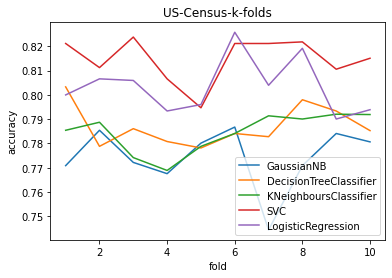

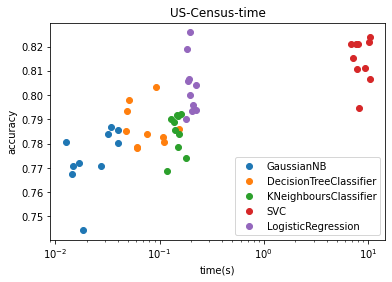

In [9]:
# gnb = GaussianNB()
# gnb.fit(trainX, trainY)
# print(gnb.predict(testX))

models = {
    "GaussianNB" : GaussianNB(),
    "DecisionTreeClassifier" : DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, random_state=42),
    "KNeighboursClassifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "SVC" : SVC(C=10, kernel="poly", random_state=42),
    "LogisticRegression": LogisticRegression(C=10, penalty = "none", random_state=42)
}

scores = {}
times = {}
cv=10
for name, model in models.items():
    cross_val = cross_validate(model, X_train, y_train, cv=cv)
    score = cross_val['test_score']
    time = np.add(cross_val['fit_time'], cross_val['score_time'])
    # print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
    scores[name] = score
    times[name] = time

for model in scores:
    plt.plot(range(1, cv+1), scores[model], label=model)

plt.xlabel('fold') 
plt.ylabel('accuracy') 
plt.title("US-Census k-folds")
plt.legend() 
plt.show()

for model in scores:
    plt.plot(times[model], scores[model], 'o', label=model)
plt.xlabel('time in seconds') 
plt.ylabel('accuracy') 
plt.title("US-Census Time")
plt.legend() 

plt.xscale('log')

plt.show()


### Question 3

In [12]:
# TODO

### Question 4

In [13]:
#TODO

### Question 5

In [14]:
#TODO
prediction = np.array([-1] * len(X_test)) #TODO replace this with you own prediction
pd.DataFrame(prediction).to_csv("GROUP_classes_problem_census.txt", index=False, header=False)